In [1]:
import numpy as np

In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')

In [3]:
class LogisticRegression(LinearModel):
    def __init__(self, eps=1e-6):
        self.eps = eps

    def fit(self, x, y):
        m, n = x.shape
        self.theta = np.zeros(n)

        while True:
            theta_old = np.copy(self.theta)

            h_x = 1 / (1 + np.exp(-x.dot(self.theta)))    # (m,)
            S = h_x * (1 - h_x)                           # (m,)
            H = (x.T * S) @ x / m                         # (n, n)
            gradient = x.T.dot(h_x - y) / m               # (n,)

            delta = np.linalg.solve(H, gradient)
            self.theta -= delta

            if np.linalg.norm(self.theta - theta_old, ord=1) < self.eps:
                break

    def predict(self, x):
        return 1 / (1 + np.exp(-x.dot(self.theta)))



In [4]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [5]:
def main(train_path, eval_path, pred_path):
    x_train, y_train = load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***

    model = LogisticRegression(eps=1e-5)
    model.fit(x_train, y_train)
    
    # Plot data and decision boundary
    plot(x_train, y_train, model.theta, '/home/vedant/Codes&Projects/CS229/problem_sets/PS_1/output/p01b_{}.png'.format(pred_path[-5]))

    # Save predictions
    x_eval, y_eval = load_dataset(eval_path, add_intercept=True)
    y_pred = model.predict(x_eval)
    np.savetxt(pred_path, y_pred > 0.5, fmt='%d')

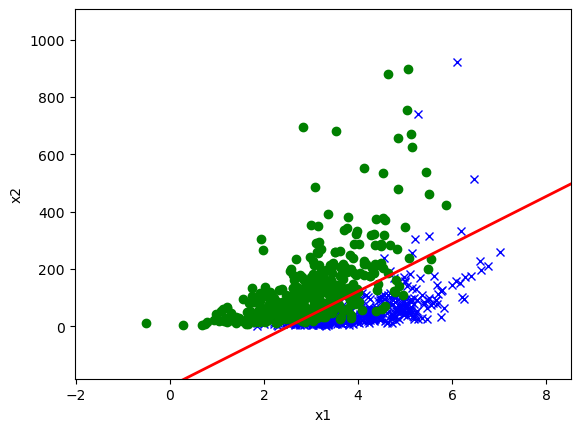

In [6]:
main(train_path='/home/vedant/Codes&Projects/CS229/problem_sets/PS_1/data/ds1_train.csv', eval_path='/home/vedant/Codes&Projects/CS229/problem_sets/PS_1/data/ds1_valid.csv', pred_path='/home/vedant/Codes&Projects/CS229/problem_sets/PS_1/output/Pred_ques_1/p01b_pred.txt')

## Using sklearn

In [11]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Load dataset with manual intercept
x_train, y_train = load_dataset(train_path, add_intercept=True)

model = LogisticRegression(fit_intercept=False)
model.fit(x_train, y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [12]:
def plot_data(x, y):
    plt.figure(figsize=(8,6))
    plt.scatter(x[y==0][:,1], x[y==0][:,2], label='Class 0', marker='o', edgecolors='k')
    plt.scatter(x[y==1][:,1], x[y==1][:,2], label='Class 1', marker='x', edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()


In [13]:
def plot_decision_boundary(theta):
    x1_vals = np.linspace(x_train[:,1].min(), x_train[:,1].max(), 100)
    x2_vals = -(theta[0] + theta[1]*x1_vals) / theta[2]

    plt.plot(x1_vals, x2_vals, 'r-', label='Decision Boundary')
    plt.legend()


/tmp/ipykernel_9228/1359099738.py:4: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x[y==1][:,1], x[y==1][:,2], label='Class 1', marker='x', edgecolors='k')


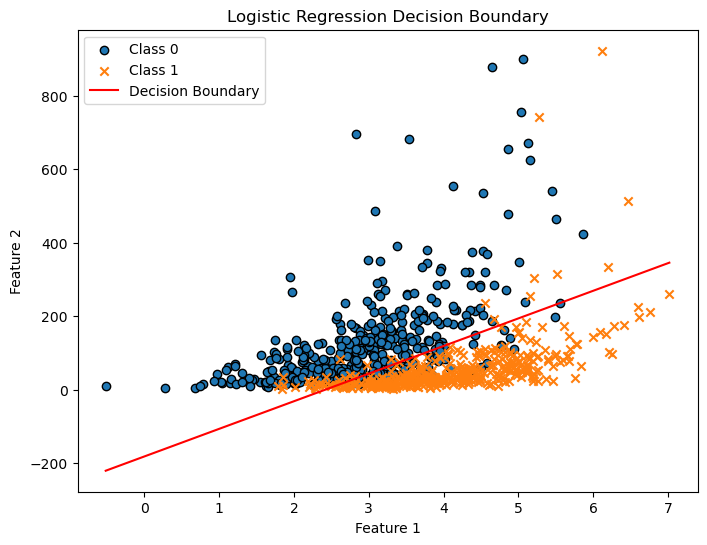

In [14]:
plot_data(x_train, y_train)
plot_decision_boundary(model.coef_.flatten())
plt.title('Logistic Regression Decision Boundary')
plt.show()
